In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from pprint import pprint
from matplotlib import cm
from ipywidgets import interact, interact_manual
from collections import defaultdict, OrderedDict, Counter
from scipy.special import gammaln, psi, multigammaln, xlogy, entr

from IPython.display import clear_output, display

import scipy.stats
import scipy as sp
import pandas as pd
import matplotlib as mpl

from plotnine import *
from plydata import *

from scipy.stats._discrete_distns import binom_gen
from scipy.special import gammaln, xlog1py, xlogy

from datasets import *

mpl.rcParams["figure.figsize"] = "11,8"

# Utils

In [5]:
def get_tosses(a_string):
    if a_string is None or a_string == '':
        return []
    without_spaces = a_string.replace(r'\s*', '')
    return [int(comp) for comp in without_spaces.split(',')]

def get_normalized_params_vector(prob, number_of_params):
    vector = np.zeros((number_of_params,))
    vector[0] = prob
    for i in range(1, number_of_params):
        vector[i] = (1 - prob) / (number_of_params - 1)
    return vector

class custom_multinomial_gen(sp.stats._multivariate.multinomial_gen):
    def _logpmf(self, x, p):
        return np.sum(xlogy(x, p), axis=-1)
    

    def logpmf(self, x, p):
        n = 1
        n, p, npcond = self._process_parameters(n, p)
        x, xcond = self._process_quantiles(x, n, p)
        result = self._logpmf(x, p)
        return result

    def pmf(self, x, p):
        return np.exp(self.logpmf(x, p))
    
custom_multinomial = custom_multinomial_gen()

# Task 1

## Without prior

In [18]:
some_numbers = widgets.Text(
    value='1',
    placeholder='Type side number...',
    description='$\mathcal{D}$=',
    disabled=False
)

params = widgets.IntSlider(
    min=2,
    max=100,
    value=2,
    description='Number of sides:'
)

def multinomial(numbers, number_of_params):
    def helper(params, occurences):
        total = 1
        for p, o in zip(params, occurences):
            total *= p ** o
        return total
    parsed_nums = get_tosses(numbers)
    counter = OrderedDict({val + 1: 0 for val in range(number_of_params)})
    for num in parsed_nums:
        counter[num] += 1
    only_values = [val for key, val in counter.items()]
    return lambda p: helper(p, only_values)

def other_multinomial(numbers, number_of_params):
    parsed_nums = get_tosses(numbers)
    counter = OrderedDict({val + 1: 0 for val in range(number_of_params)})
    for num in parsed_nums:
        counter[num] += 1
    only_values = [val for key, val in counter.items()]
    return lambda p: custom_multinomial.pmf(x=only_values, p=p)

generated = False
@interact(numbers=some_numbers, params=params)
def calc_likelihood(numbers, params):
    model = other_multinomial(numbers, params)
    space = np.linspace(0, 1, 100)
    x = []
    y = []
    for prob in space:
        normalized_params_vector = get_normalized_params_vector(prob, params)
        x.append(prob)
        y.append(model(normalized_params_vector))
    
    frame = pd.DataFrame(data={'p_b':x, 'likelihood':y})
    print(ggplot(aes(x='p_b', y='likelihood'), data=frame) +
         geom_line(color="blue")+
          xlab("$p_1$") +
          ylab("$\mathcal{L}(\mathcal{D} | \\theta)$") +
          ggtitle('Wizualizacja dla próbki o klasie 1') + 
         theme_minimal()) 

interactive(children=(Text(value='1', description='$\\mathcal{D}$=', placeholder='Type side number...'), IntSlider(value=2, description='Number of sides:', min=2), Output()), _dom_classes=('widget-interact',))

## With prior

In [7]:
params = widgets.IntSlider(
    min=2,
    max=100,
    value=2,
    description='Number of sides:'
)

total_params = 0
@interact(params=params)
def change_nb_params(params):
    global total_params
    total_params = params

interactive(children=(IntSlider(value=2, description='Number of sides:', min=2), Output()), _dom_classes=('widget-interact',))

In [8]:
some_numbers = widgets.Text(
    value='1',
    placeholder='Type side number...',
    description='$\mathcal{D}$=',
    disabled=False
)

alphas = {
    f'alpha_{i}': widgets.FloatSlider(
        min=0,
        max=20,
        value=1,
        description="$\\alpha_" + str(i) + "$",
    ) for i in range(total_params)
}
alphas['some_numbers'] = some_numbers

def get_multinomial_model(numbers, total_params=total_params):
    parsed_nums = get_tosses(numbers)
    counter = OrderedDict({val + 1: 0 for val in range(total_params)})
    for num in parsed_nums:
        counter[num] += 1
    only_values = [val for key, val in counter.items()]
    return lambda p: custom_multinomial.pmf(x=only_values, p=p)

def get_dirichlet_model(numbers, alphas, total_params=total_params):
    parsed_nums = get_tosses(numbers)
    counter = OrderedDict({val + 1: 0 for val in range(total_params)})
    for num in parsed_nums:
        counter[num] += 1
    only_values = [val for key, val in counter.items()]
    return lambda p: sp.stats.dirichlet.pdf(x=p, alpha=alphas)


def get_multinomial_dirichlet_model(numbers, alphas, total_params=total_params):
    parsed_nums = get_tosses(numbers)
    counter = OrderedDict({val + 1: 0 for val in range(total_params)})
    for num in parsed_nums:
        counter[num] += 1
    only_values = [val + alphas[i] for i, (key, val) in enumerate(counter.items())]
    return lambda p: sp.stats.dirichlet.pdf(x=p, alpha=only_values)
    

generated_prior = False

@interact(**alphas)
def plot(**kwargs):
    numbers = kwargs['some_numbers']
    alphas = [alpha for key, alpha in kwargs.items() if 'alpha' in key]
    mult_dirich_model = get_multinomial_dirichlet_model(numbers, alphas)
    dirich_model = get_dirichlet_model(numbers, alphas)get_normalized_params_vector
    mult_model = get_multinomial_model(numbers)get_normalizeget_normalized_params_vectord_params_vector
    probs = np.linspace(0.001, 0.999, 100)
    x = []
    y = []
    model_name = []
    
    data = defaultdict(list)
    
    for prob in probs:
        normalized_params_vector = get_normalized_params_vector(prob, total_params)
        x.append(prob)
        y.append(mult_dirich_model(normalized_params_vector))
        model_name.append('multinomial dirichlet')
        data['multinomial dirichlet'].append(mult_dirich_model(normalized_params_vector))
        
        x.append(prob)
        y.append(dirich_model(normalized_params_vector))
        model_name.append('dirichlet')
        data['dirichlet'].append(dirich_model(normalized_params_vector))
        
        x.append(prob)
        y.append(mult_model(normalized_params_vector) * 10)
        model_name.append('multinomial')
        data['multinomial'].append(mult_model(normalized_params_vector) * 100)
        
        x.append(prob)
        y.append(mult_model(normalized_params_vector) * dirich_model(normalized_params_vector) * 5)
        model_name.append("prior likelihood multiplication")
        data['prior likelihood multiplication'].append(mult_model(normalized_params_vector) * dirich_model(normalized_params_vector) * 5)
        
    frame = pd.DataFrame(data={'p_b':x, 'likelihood':y, 'model_name': model_name})
    
    for key, val in data.items():
        print(f'{key}: {probs[np.argmax(val)]}')
    
    print(ggplot(aes(x='p_b', y='likelihood', group='model_name', colour="model_name"), data=frame) +
         geom_line()+
          xlab("$p_1$") +
         ylab("Posterior") +
         theme_minimal()) 

interactive(children=(FloatSlider(value=1.0, description='$\\alpha_0$', max=20.0), FloatSlider(value=1.0, description='$\\alpha_1$', max=20.0), FloatSlider(value=1.0, description='$\\alpha_2$', max=20.0), FloatSlider(value=1.0, description='$\\alpha_3$', max=20.0), FloatSlider(value=1.0, description='$\\alpha_4$', max=20.0), Text(value='1', description='$\\mathcal{D}$=', placeholder='Type side number...'), Output()), _dom_classes=('widget-interact',))

# Task 2

In [9]:
params_2 = widgets.IntSlider(
    min=2,
    max=100,
    value=2,
    description='Number of sides:'
)

total_params_2 = 0
@interact(params=params_2)
def change_nb_params(params):
    global total_params_2
    total_params_2 = params

interactive(children=(IntSlider(value=2, description='Number of sides:', min=2), Output()), _dom_classes=('widget-interact',))

In [19]:
import random

number_of_samles = widgets.IntSlider(
    value=10000,
    min=0,
    max=1e10,
    description="$|D|$",
    continuous_update=False
)

alphas_2 = {
    f'alpha_{i}': widgets.FloatSlider(
        min=0,
        max=20,
        value=1,
        description="$\\alpha_" + str(i + 1) + "$",
        continuous_update=False
    ) for i in range(total_params_2)
}
alphas_2['number_of_samples'] = number_of_samles

output = [widgets.Text(
    value="",
    disabled=True,
    description="$p (X = " + str(_) + " | \mathcal{D}) =$"
) for _ in range(total_params_2)]

def posterior_predictive(cls_counter, alphas):
    da_sum = sum(val for val in cls_counter.values())
    cls_probs = {
        cls: (alphas[cls - 1] + cls_counter[cls]) / da_sum
        for cls in cls_counter.keys()
    }
    return cls_probs

@interact(**alphas_2)
def plot(**kwargs):
    number_of_samples = kwargs['number_of_samples']
    alphas = [alpha for key, alpha in kwargs.items() if 'alpha' in key]
    possible_outcomes = list(range(1, total_params_2 + 1))
    counter = defaultdict(int)
    all_data = defaultdict(list)
    for _ in range(number_of_samples):
        counter[random.choice(possible_outcomes)] += 1
        if _ > 100:
            for key, val in posterior_predictive(counter, alphas).items():
                all_data['val'].append(val)
                all_data['Parameter'].append(str(key))
                all_data['total'].append(_)
    
    elems = [(key, val) for key, val in posterior_predictive(counter, alphas).items()]
    
    sorted_elems = list(sorted(elems, key=lambda item: item[0]))
    for i, out in enumerate(output):
        out.value = "%.5f" % (sorted_elems[i][1])
        display(out)
    all_data = pd.DataFrame(data=all_data)
    all_data['Parameter'] = all_data['Parameter'].replace({str(key): '$\\theta_' + str(key) + '$' for key in possible_outcomes})
    print(ggplot(aes(x='total', y='val', group='Parameter', colour="Parameter"), data=all_data) +
         geom_line()+
          xlab("Number of samples") +
         ylab("$p(X = j | \\mathcal{D})$") +
         theme_xkcd()) 

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='$\\alpha_1$', max=20.0), FloatSlider(value=1.0, continuous_update=False, description='$\\alpha_2$', max=20.0), FloatSlider(value=1.0, continuous_update=False, description='$\\alpha_3$', max=20.0), FloatSlider(value=1.0, continuous_update=False, description='$\\alpha_4$', max=20.0), FloatSlider(value=1.0, continuous_update=False, description='$\\alpha_5$', max=20.0), IntSlider(value=10000, continuous_update=False, description='$|D|$', max=10000000000), Output()), _dom_classes=('widget-interact',))

# Task 3

In [12]:
from datasets import *
from models import *

In [13]:
data = defaultdict(list)
for cond in [True, False]:
    for name, d in datasets_with_names:
        model = Model()
        train, test = d(cond).train_test_split()
        data['Dataset name'].append(name)
        data['Use lemmatizer'].append(cond)
        model.fit_thetas(train)
        data['Accuracy'].append(model.score_not_online(test))


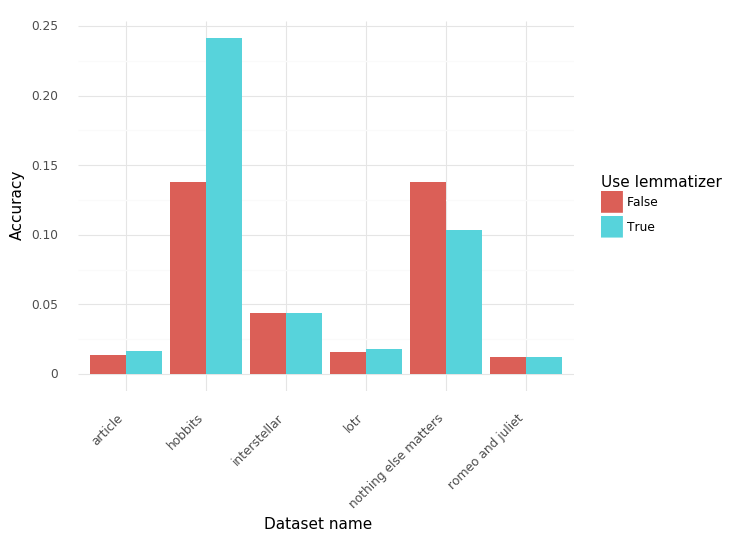

<ggplot: (-9223363265739704211)>

In [20]:
pd_data = pd.DataFrame(data=data)

(ggplot(aes(x='Dataset name', y='Accuracy', fill='Use lemmatizer'), data=pd_data) 
    + geom_bar(stat='identity', position='dodge')
    + theme_minimal()
    + theme(axis_text_x=(element_text(angle=45, hjust=1))))

In [16]:
pd_data

Accuracy          Dataset name  Use lemmatizer
0   0.103448  nothing else matters            True
1   0.241379               hobbits            True
2   0.043478          interstellar            True
3   0.012503      romeo and juliet            True
4   0.016754               article            True
5   0.018222                  lotr            True
6   0.137931  nothing else matters           False
7   0.137931               hobbits           False
8   0.043478          interstellar           False
9   0.012503      romeo and juliet           False
10  0.013655               article           False
11  0.015482                  lotr           False